In [2]:
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

In [3]:
#from gnn_tracking.postprocessing.clusterscanner import ClusterHyperParamScanner
import optuna
import numpy as np
from sklearn.cluster import DBSCAN

from sklearn.datasets import make_blobs

from sklearn import metrics

In [4]:
# def gen_sample():
#     # n_clusters = np.random.randint(2, 4)
#     # centers = np.random.uniform(0, 5, size=(n_clusters, 2))
#     # X, labels_true = make_blobs(
#     #     n_samples=750, centers=centers, cluster_std=0.4, random_state=0
#     # )
#     centers = [[1, 1], [-1, -1], [1, -1]]
#     X, labels_true = make_blobs(
#         n_samples=750, centers=centers, cluster_std=0.4
#     )
#     return X, labels_true

In [5]:
from pathlib import Path

datadir = Path("~/data/gnn_tracking/clust").expanduser()
names = [
    "0_0",
    "1_5",
    "2_8",
    "3_9",
    "4_15",
    "5_16",
    "6_20",
    "7_25",
    "8_30",
    "9_31",
]
graphs = []
truths = []
for name in names:
    graphs.append(np.load(datadir / f"{name}.npy"))
    truths.append(np.load(datadir / f"t_{name}.npy"))


In [106]:
truths[0].shape

(2657,)

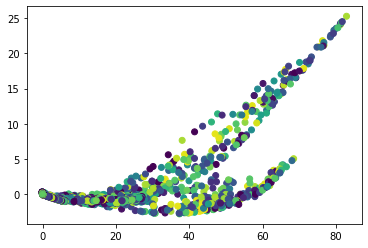

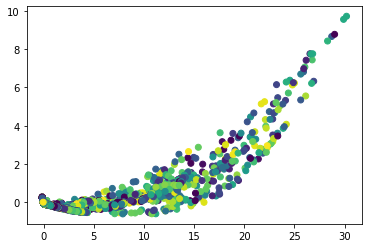

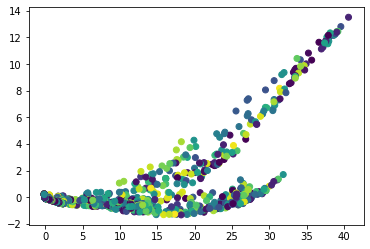

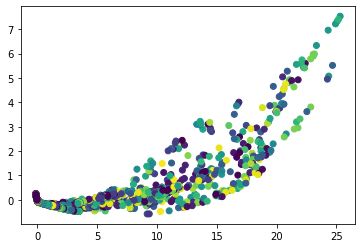

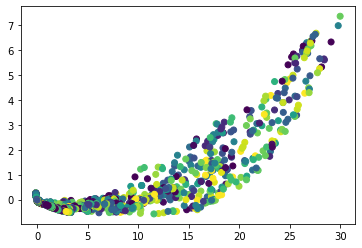

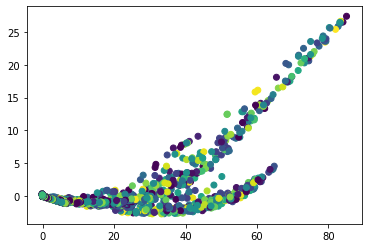

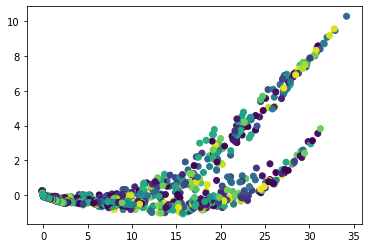

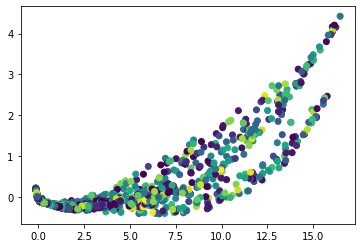

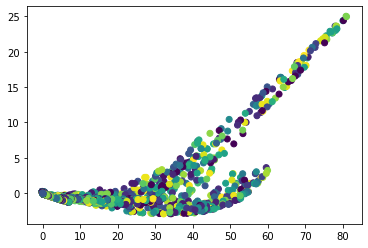

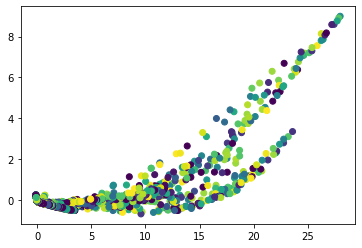

In [118]:
for i in range(10):
    plt.scatter(graphs[i][:, 0], graphs[i][:, 1], c=truths[i])
    plt.show()

In [114]:
len(np.unique(truths[0]))

512

In [115]:
len(truths[0])

2657

In [119]:
from abc import ABC, abstractmethod
from typing import Callable
import pandas as pd





def expensive_metric(*, truth, predicted) -> float:
    c_id = pd.DataFrame({'c': predicted, 'id': truth})
    clusters = c_id.groupby('c')
    # majority_pid = clusters['id'].apply(lambda x: x.mode()[0])
    majority_counts = clusters['id'].apply(lambda x: sum(x==x.mode()[0]))
    majority_fraction = clusters['id'].apply(lambda x: sum(x==x.mode()[0])/len(x))
    h_id = pd.DataFrame({'hits': np.ones(len(predicted)), 'id': truth})
    particles = h_id.groupby('id')
    nhits = particles['hits'].apply(lambda x: len(x)).to_dict()
    majority_hits = clusters['id'].apply(lambda x: x.mode().map(nhits)[0])
    # perfect_match = ((majority_hits==majority_counts) &
    #                  (majority_fraction > 0.99))
    double_majority = (((majority_counts / majority_hits).fillna(0) > 0.5) &
                       (majority_fraction > 0.5))
    return sum(double_majority) / len(predicted)




In [120]:
from gnn_tracking.postprocessing.clusterscanner import ClusterHyperParamScanner
from gnn_tracking.utils.earlystopping import RelEarlyStopper

es = RelEarlyStopper(wait=30, grace=50, change_threshold=0.01, direction="max")

def dbscan(graph, eps, min_samples):
    return DBSCAN(eps=eps, min_samples=min_samples).fit_predict(graph)

def cheap_metric(labels, truth):
    return metrics.v_measure_score(truth, labels)

chps=ClusterHyperParamScanner(dbscan, graphs, truths, expensive_metric, cheap_metric=metrics.v_measure_score, early_stopping=es)

In [122]:
study = chps.scan(n_trials=10)

[I 2022-09-09 18:25:30,461] Trial 1 finished with value: 0.0 and parameters: {'eps': 0.8846792746337403, 'min_samples': 9}. Best is trial 0 with value: 0.0.
[I 2022-09-09 18:25:30,670] Trial 2 finished with value: 0.0 and parameters: {'eps': 0.06353144131057592, 'min_samples': 21}. Best is trial 0 with value: 0.0.
[I 2022-09-09 18:25:30,916] Trial 3 finished with value: 0.0 and parameters: {'eps': 0.7134100304898473, 'min_samples': 24}. Best is trial 0 with value: 0.0.
[I 2022-09-09 18:25:31,171] Trial 4 finished with value: 0.0 and parameters: {'eps': 0.7646459387805188, 'min_samples': 26}. Best is trial 0 with value: 0.0.
[I 2022-09-09 18:25:31,478] Trial 5 finished with value: 0.0 and parameters: {'eps': 0.35449175262065363, 'min_samples': 6}. Best is trial 0 with value: 0.0.
[I 2022-09-09 18:25:31,537] Trial 6 pruned. 
[I 2022-09-09 18:25:31,783] Trial 7 finished with value: 0.0 and parameters: {'eps': 0.5900758984456247, 'min_samples': 39}. Best is trial 0 with value: 0.0.
[I 2022

In [88]:
from optuna.visualization import plot_contour

In [99]:
study.best_params

{'eps': 7.66060384233408e-05, 'min_samples': 1}

In [100]:
plot_contour(study)

In [101]:
from optuna.visualization import plot_slice

plot_slice(study)

In [102]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)